# Shoreline extraction at the benchmark sites with CoastSat


This notebook shows how to extract time-series of shoreline change at the 4 benchmark sites using the CoastSat toolbox.

## Initial settings

Refer to the **Installation** section of the [CoastSat README](https://github.com/kvos/CoastSat) for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [2]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from scipy import interpolate
from scipy import stats
import pytz
import json 
# load coastsat package located under algorithms/COASTSAT/
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

# filepaths to all the datasets
fp_datasets = os.path.join(os.path.join(os.pardir,os.pardir,'datasets'))
names_datasets = os.listdir(fp_datasets)
names_datasets = [_ for _ in names_datasets if _ not in ['README.md','sites_info.txt']]
print('\nBenchmark datasets available:\n%s'%(names_datasets))
                
# load site info dict if exists or create
fp_info = os.path.join(fp_datasets,'sites_info.txt')
if os.path.exists(fp_info):
    with open(fp_info,'r') as f: sites_info = json.load(f)  
    print('\nLoaded sites_info.txt.')
else:
    sites_info = {'NARRABEEN':{'beach_slope':0.1,'contour_level':0.7,'epsg':28356},
                  'DUCK':{'beach_slope':0.1,'contour_level':0.4,'epsg':32119},
                  'TRUCVERT':{'beach_slope':0.05,'contour_level':1.5,'epsg':32630},
                  'TORREYPINES':{'beach_slope':0.035,'contour_level':1.6,'epsg':26946},
                 }
    with open(fp_info,'w') as f: json.dump(sites_info,f,indent=4)
for key in sites_info.keys(): print('%s: %s'%(key,sites_info[key]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Benchmark datasets available:
['DUCK', 'NARRABEEN', 'TORREYPINES', 'TRUCVERT']

Loaded sites_info.txt.
NARRABEEN: {'beach_slope': 0.1, 'contour_level': 0.7, 'epsg': 28356}
DUCK: {'beach_slope': 0.1, 'contour_level': 0.4, 'epsg': 32119}
TRUCVERT: {'beach_slope': 0.05, 'contour_level': 1.5, 'epsg': 32630}
TORREYPINES: {'beach_slope': 0.035, 'contour_level': 1.6, 'epsg': 26946}


## Retrieval of the images from GEE for the test sites

Here we download all the Landsat (5,7,8,9) amd Sentinel-2 images between 1984 and 2022 for the benchmark sites using the provided ROIs.

In [ ]:
# satellites to include
sat_list = ['L5','L7','L8','S2']
# choose Landsat collection 'C01' or 'C02'
landsat_collection = 'C01'
# dates
dates = ['1984-01-01', '2022-01-01']
# folder to save the images in
fp_images = os.path.join(os.getcwd(),'satellite_data')
# loop over each site
for sitename in names_datasets:
    print(sitename)
    data_folder = os.path.join(fp_datasets,sitename)
    # load polygon ROI
    fn_polygon = os.path.join(data_folder, '%s_polygon.geojson'%sitename)
    gdf_polygon = gpd.read_file(fn_polygon)
    polygon = np.array(gdf_polygon.loc[0,'geometry'].exterior.coords)
    # create inputs dictionary
    inputs = {}
    inputs['sitename'] = sitename
    inputs['polygon'] = [[[_[0], _[1]] for _ in polygon]]
    inputs['sat_list'] = sat_list
    inputs['dates'] = dates
    inputs['landsat_collection'] = landsat_collection
    inputs['filepath'] = fp_images
    if os.path.exists(os.path.join(fp_images,sitename,sitename+'_metadata.pkl')): continue
    # download the imagery
    metadata = SDS_download.retrieve_images(inputs)

## 1. Narrabeen

In [2]:
# loop over each site (for the moment only NARRABEEN)
sitename = 'NARRABEEN'
inputs = {}
inputs['sitename'] = sitename
inputs['filepath'] =  os.path.join(os.getcwd(),'satellite_data')
inputs['landsat_collection'] = 'C01'
inputs['dates'] =  ['1984-01-01', '2022-01-01']
inputs['sat_list'] = ['L5','L7','L8','S2']
data_folder = os.path.join(fp_datasets,sitename)

metadata = SDS_download.get_metadata(inputs)
# remove S2 for the time being
metadata.pop('S2');

### Shoreline extraction (fully automated)

Loaded reference shoreline in epsg:4326
Converted to epsg:28356
Mapping shorelines:
L5:   100%
L7:   100%
L8:   100%
88 duplicates
0 bad georef
0 / 539 images different size
1 / 539 images wrong classif
0% images removed
Mean clasification image was saved in C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\classif_qa.jpg


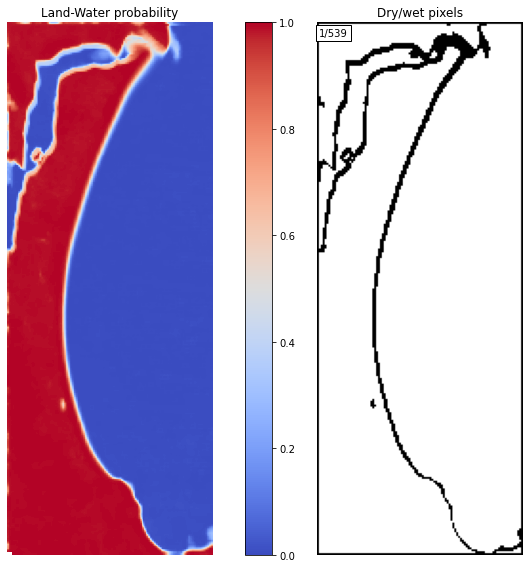

In [8]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 28356,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': False,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    # add the inputs defined previously
    'inputs': inputs,
}
# take epsg from sites_info 
settings['output_epsg'] = sites_info[sitename]['epsg']
# load the reference shoreline
fn_refsl = os.path.join(data_folder, '%s_reference_shoreline.geojson'%sitename)
gdf_refsl = gpd.read_file(fn_refsl)
print('Loaded reference shoreline in epsg:%d'%gdf_refsl.crs.to_epsg())
gdf_refsl.to_crs(epsg=settings['output_epsg'], inplace=True)
print('Converted to epsg:%d'%gdf_refsl.crs.to_epsg())
refsl = np.array(gdf_refsl.loc[0,'geometry'].coords)
settings['reference_shoreline'] = refsl
# set the max distance (in meters) allowed from the reference shoreline for a detected shoreline to be valid
settings['max_dist_ref'] = 100
# extract shorelines from all images (creates or loads output.pkl)
fn_output = os.path.join(inputs['filepath'], sitename, sitename + '_output' + '.pkl')
if os.path.exists(fn_output):
    with open(fn_output, 'rb') as f:
        output = pickle.load(f)
    print('loaded existing file at %s'%fn_output)
else:
    output = SDS_shoreline.extract_shorelines(metadata, settings)
    # remove duplicates (images taken on the same date by the same satellite)
    output = SDS_tools.remove_duplicates(output)
    # remove inaccurate georeferencing (set threshold to 10 m)
    output = SDS_tools.remove_inaccurate_georef(output, 10)
    # remove bad images based on average classification (only works for same resolution, Landsat)
    if not 'S2' in metadata.keys():
        # settings for discarding the badly classified images"
        settings['prc_pixel'] = 0.15    # minimum percentage of change from land to water for defining the wet/dry areas
        settings['prc_image'] = 0.3     # maximum percentage of misclassified pixels allowed in the image, otherwise discarded
        output = SDS_shoreline.remove_bad_images(output,settings)
    else:
        output.pop('im_classif')
        with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'wb') as f:
            pickle.dump(output,f)

### Shoreline analysis

Loaded transects in epsg:4326
Converted to epsg:28356
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF1_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF2_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF4_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF6_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF8_timeseries_raw.csv


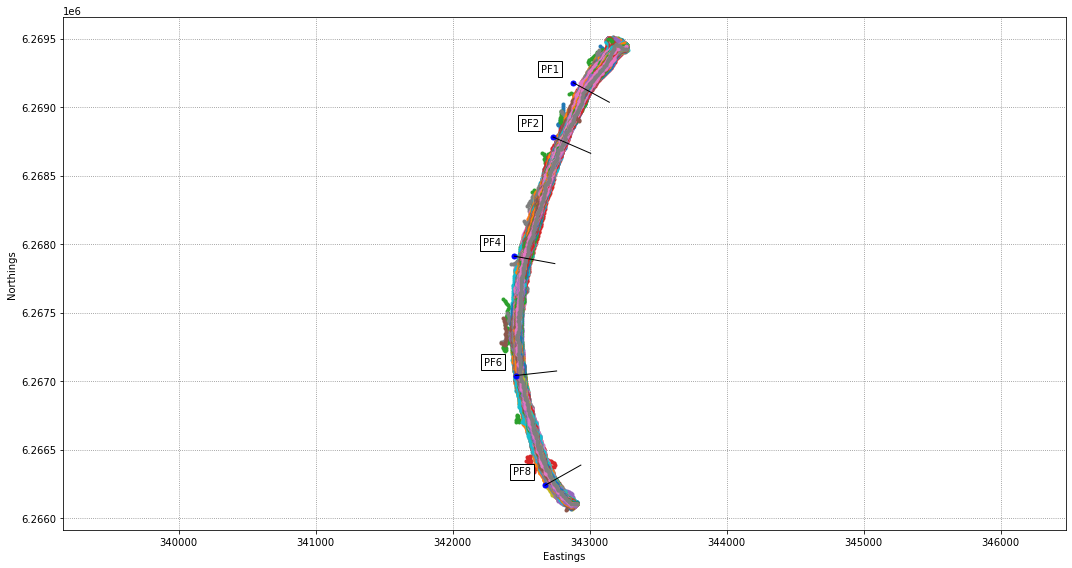

In [9]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)

# for GIS applications, save output into a GEOJSON layer
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = {'init':'epsg:'+str(settings['output_epsg'])} # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

# load transects
fn_transects = os.path.join(data_folder, '%s_transects.geojson'%sitename)
gdf_transects = gpd.read_file(fn_transects)
print('Loaded transects in epsg:%d'%gdf_transects.crs.to_epsg())
gdf_transects.to_crs(epsg=settings['output_epsg'], inplace=True)
print('Converted to epsg:%d'%gdf_transects.crs.to_epsg())
# put transects into a dictionary with their name
transects = dict([])
for i in gdf_transects.index:
    transects[gdf_transects.loc[i,'name']] = np.array(gdf_transects.loc[i,'geometry'].coords)

# plot the transects to make sure they are correct (origin landwards!)
%matplotlib inline
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'mapped_shorelines.jpg'),dpi=200)

# compute the intersections
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'prc_multiple':         0.1,      # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

# save a .csv file for each transect for submission
for key in transects.keys():
    out_dict = dict([])
    out_dict['dates'] = output['dates']
    out_dict[key] = cross_distance[key]
    out_dict['satname'] = output['satname']
    df = pd.DataFrame(out_dict)
    df.index=df['dates']
    df.pop('dates')
    fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                      '%s_timeseries_raw.csv'%key)
    df.to_csv(fn, sep=',')
    print('saved: %s'%fn)

### Tidal correction

Extracting closest points: 100%PF1  - outliers removed: 2
PF2  - outliers removed: 4
PF4  - outliers removed: 3
PF6  - outliers removed: 1
PF8  - outliers removed: 2
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF1_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF2_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF4_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF6_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\NARRABEEN\PF8_timeseries_tidally_corrected.csv


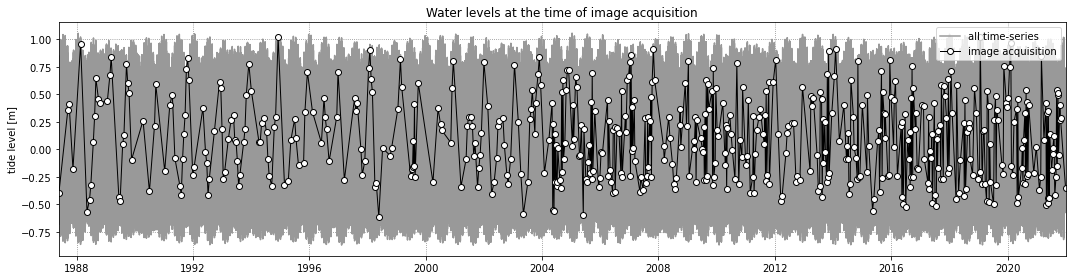

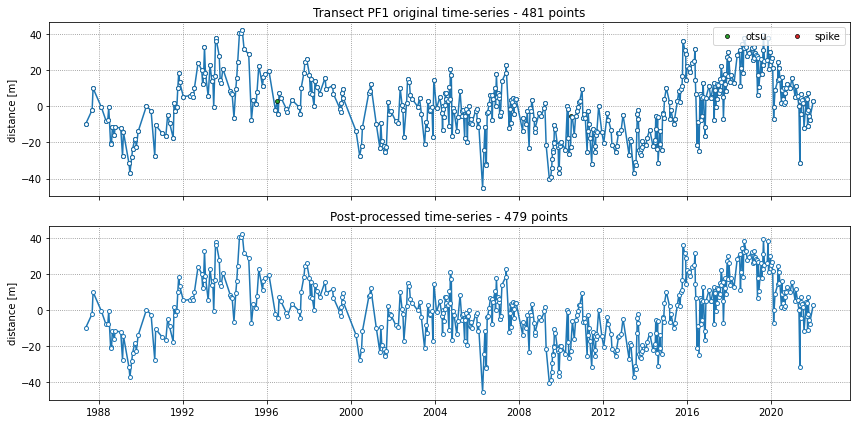

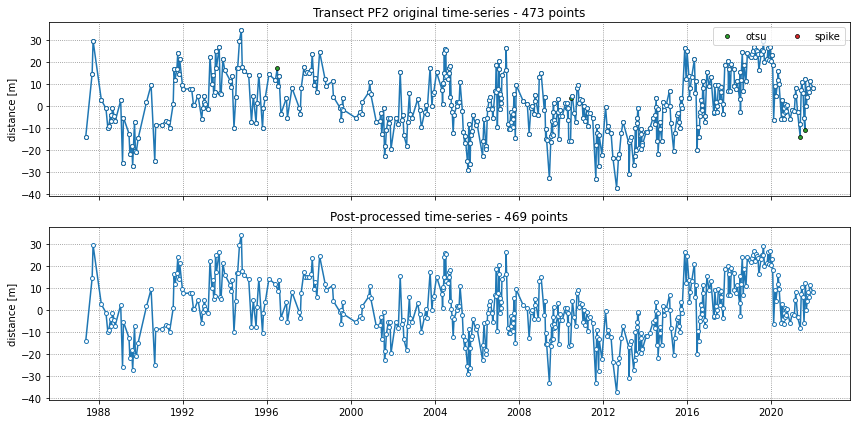

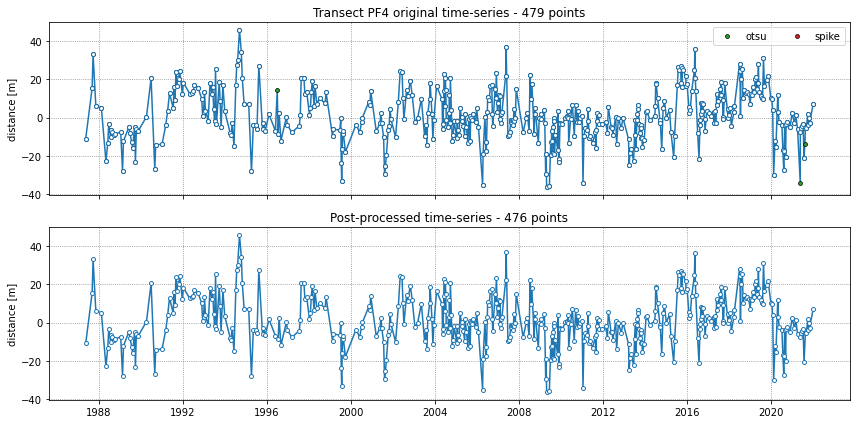

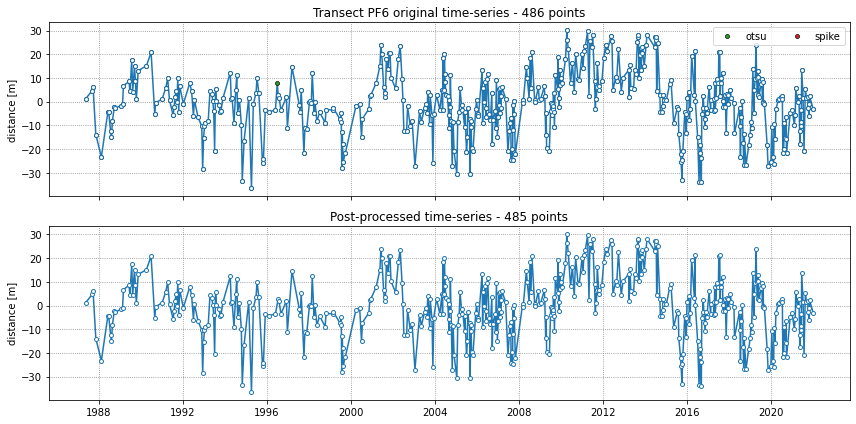

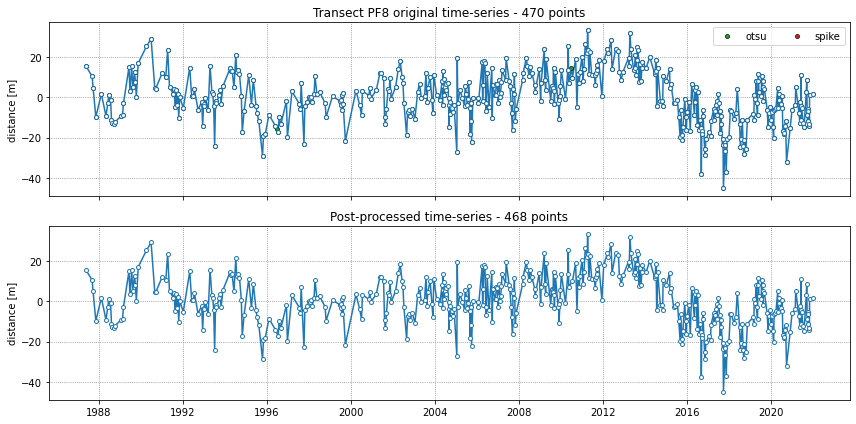

In [10]:
# load tide time-series
fn_tides = os.path.join(data_folder,'%s_tides.csv'%sitename)
tide_data = pd.read_csv(fn_tides, parse_dates=['dates'])
dates_ts = [pytz.utc.localize(_.to_pydatetime()) for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tides'])

# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)

# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(tide_data['dates'], tide_data['tides'], '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Water levels at the time of image acquisition')
ax.legend()
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'tide_timeseries.jpg'),dpi=200)

# tidal correction along each transect
reference_elevation = sites_info[sitename]['contour_level'] # elevation at which you would like the shoreline time-series to be
beach_slope = sites_info[sitename]['beach_slope']
cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/beach_slope
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    
# remove outliers in the time-series (despiking)
settings_outliers = {'otsu_threshold':     [-.5,0],       # min and max intensity threshold use for contouring the shoreline
                     'max_cross_change':   40,            # maximum cross-shore change observable between consecutive timesteps
                     'plot_fig':           True,          # whether to plot the intermediate steps
                    }
cross_distance_tidally_corrected = SDS_transects.reject_outliers(cross_distance_tidally_corrected,output,settings_outliers)

# save a .csv file for each transect for submission
for key in transects.keys():
    out_dict = dict([])
    out_dict['dates'] = output['dates']
    out_dict[key] = cross_distance_tidally_corrected[key]
    out_dict['satname'] = output['satname']
    df = pd.DataFrame(out_dict)
    df.index=df['dates']
    df.pop('dates')
    fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                      '%s_timeseries_tidally_corrected.csv'%key)
    df.to_csv(fn, sep=',')
    print('saved: %s'%fn)
    
# plot the time-series of shoreline change (both raw and tidally-corrected)
# fig = plt.figure(figsize=[15,15], tight_layout=True)
# gs = gridspec.GridSpec(len(cross_distance),1)
# gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.1)
# for i,key in enumerate(cross_distance.keys()):
#     if np.all(np.isnan(cross_distance[key])):
#         continue
#     ax = fig.add_subplot(gs[i,0])
#     ax.grid(linestyle=':', color='0.5')
#     ax.plot(output['dates'], cross_distance[key]- np.nanmedian(cross_distance[key]), '-o', ms=4, mfc='w', label='raw')
#     ax.set_ylabel('distance [m]', fontsize=12)
#     ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
#             va='top', transform=ax.transAxes, fontsize=14)
# ax.legend();
# fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'shoreline_timeseries.jpg'),dpi=200)


### Compare to groundtruth

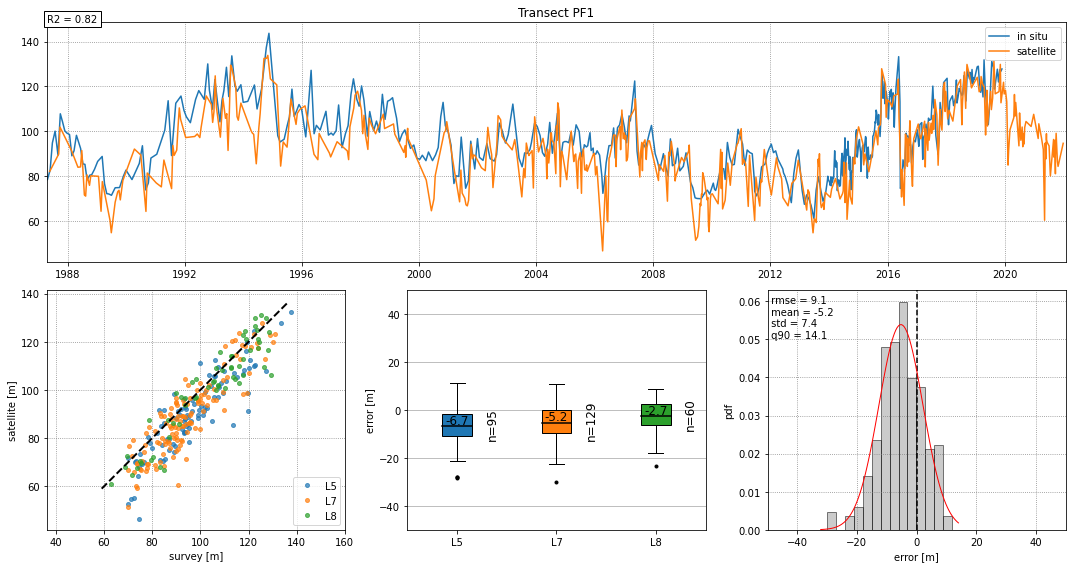

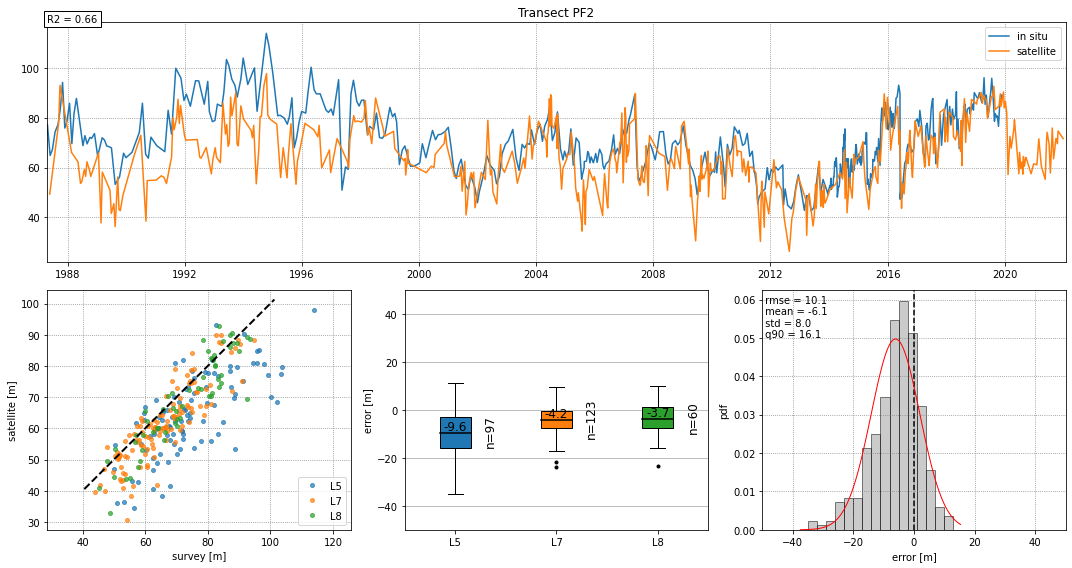

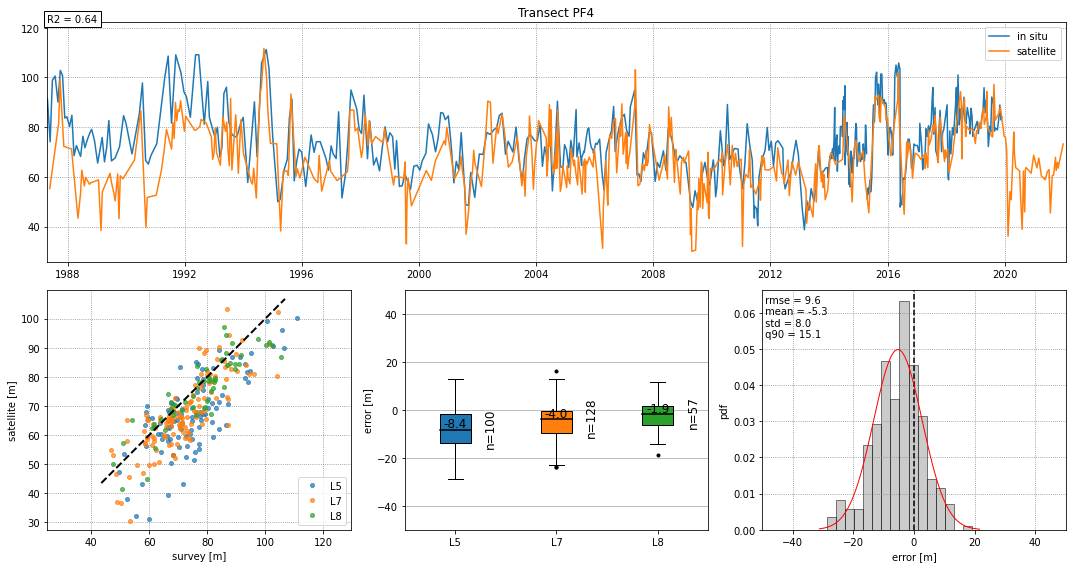

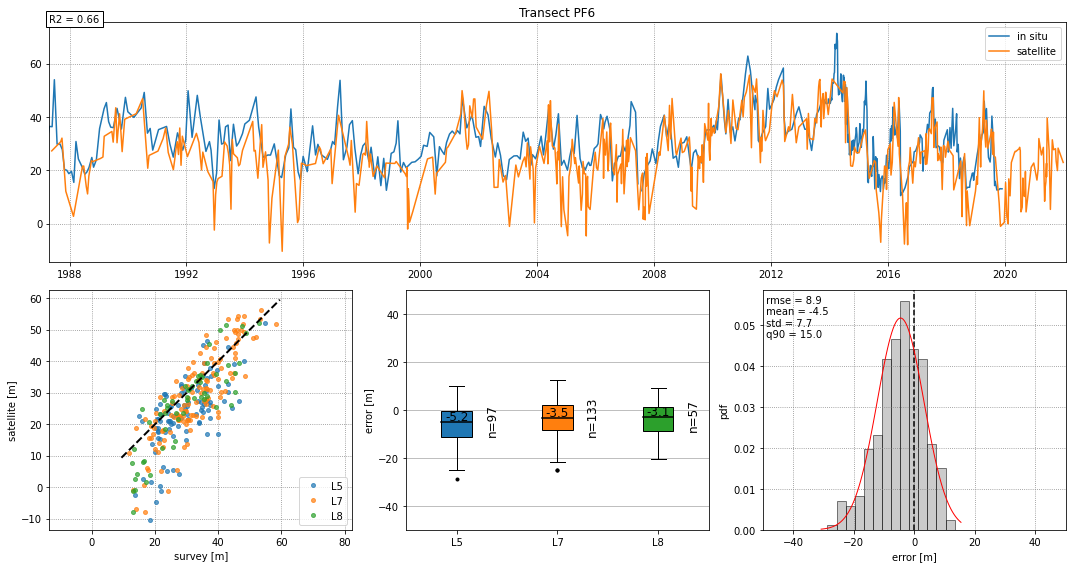

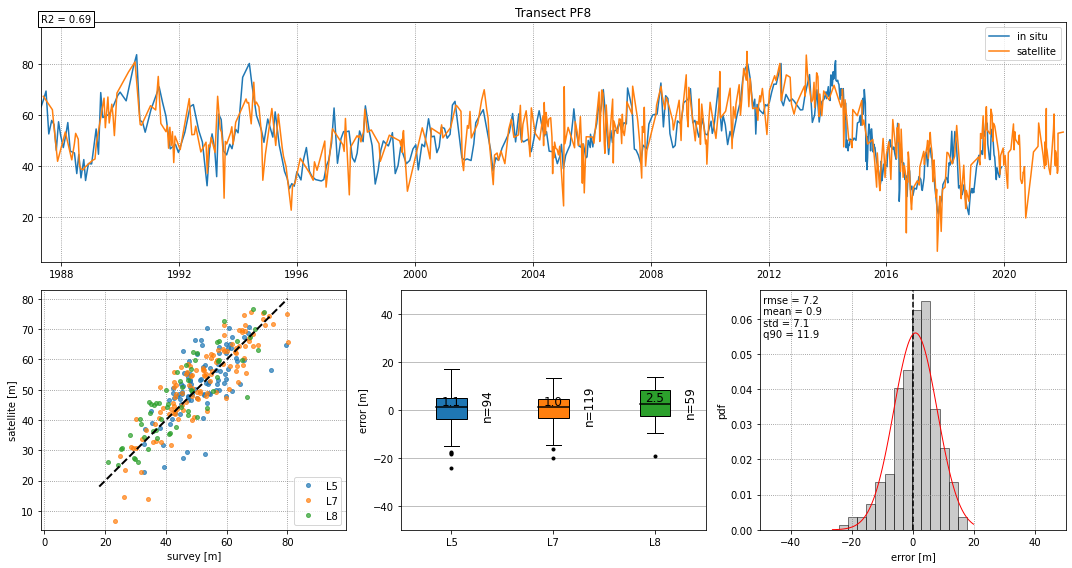

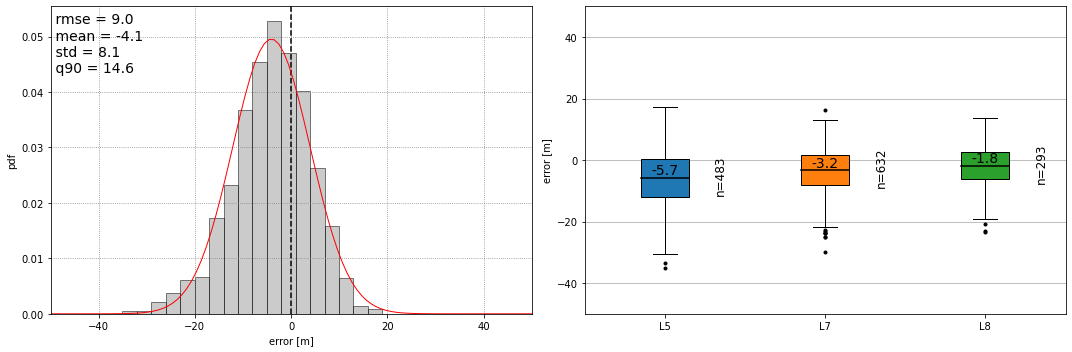

In [11]:
# set parameters for comparing the two time-series
sett = {'min_days':  3,       # numbers of days difference under which to use nearest neighbour interpolation
        'max_days':  10,      # maximum number of days difference to do a comparison
        'binwidth':  3,       # binwidth for histogram plotting
        'lims':      [-50,50] # cross-shore change limits for plotting purposes
       }
# load survey data
with open(os.path.join(data_folder, '%s_groundtruth.pkl'%sitename), 'rb') as f:
    gt = pickle.load(f)
    
# initialise variables
chain_sat_all = []
chain_sur_all = []
satnames_all = []
for key in cross_distance_tidally_corrected.keys():
    # remove nans
    chainage = cross_distance_tidally_corrected[key]
    idx_nan = np.isnan(chainage)
    dates_nonans = [output['dates'][k] for k in np.where(~idx_nan)[0]]
    satnames_nonans = [output['satname'][k] for k in np.where(~idx_nan)[0]]
    chain_nonans = chainage[~idx_nan]
    # define satellite and survey time-series
    chain_sat_dm = chain_nonans
    chain_sur_dm = gt[key]['chainages']
    # plot the time-series
    fig= plt.figure(figsize=[15,8], tight_layout=True)
    gs = gridspec.GridSpec(2,3)
    ax0 = fig.add_subplot(gs[0,:])
    ax0.grid(which='major',linestyle=':',color='0.5')
    ax0.plot(gt[key]['dates'], chain_sur_dm, '-',mfc='w',ms=5,label='in situ')
    ax0.plot(dates_nonans, chain_sat_dm,'-',mfc='w',ms=5,label='satellite')
    ax0.set(title= 'Transect ' + key, xlim=[output['dates'][0]-timedelta(days=30),
                                           output['dates'][-1]+timedelta(days=30)])#,ylim=sett['lims'])
    ax0.legend()
    # interpolate surveyed data around satellite data based on the parameters (min_days and max_days)
    chain_int = np.nan*np.ones(len(dates_nonans))
    for k,date in enumerate(dates_nonans):
        # compute the days distance for each satellite date
        days_diff = np.array([ (_ - date).days for _ in gt[key]['dates']])
        # if nothing within max_days put a nan
        if np.min(np.abs(days_diff)) > sett['max_days']:
            chain_int[k] = np.nan
        else:
            # if a point within min_days, take that point (no interpolation)
            if np.min(np.abs(days_diff)) < sett['min_days']:
                idx_closest = np.where(np.abs(days_diff) == np.min(np.abs(days_diff)))
                chain_int[k] = float(gt[key]['chainages'][idx_closest[0][0]])
            else: # otherwise, between min_days and max_days, interpolate between the 2 closest points
                if sum(days_diff > 0) == 0:
                    break
                idx_after = np.where(days_diff > 0)[0][0]
                idx_before = idx_after - 1
                x = [gt[key]['dates'][idx_before].toordinal() , gt[key]['dates'][idx_after].toordinal()]
                y = [gt[key]['chainages'][idx_before], gt[key]['chainages'][idx_after]]
                f = interpolate.interp1d(x, y,bounds_error=True)
                chain_int[k] = float(f(date.toordinal()))
    # remove nans again
    idx_nan = np.isnan(chain_int)
    chain_sat = chain_nonans[~idx_nan]
    chain_sur = chain_int[~idx_nan]
    dates_sat = [dates_nonans[k] for k in np.where(~idx_nan)[0]]
    satnames = [satnames_nonans[k] for k in np.where(~idx_nan)[0]]
    chain_sat_all = np.append(chain_sat_all,chain_sat)
    chain_sur_all = np.append(chain_sur_all,chain_sur)
    satnames_all = satnames_all + satnames
    # error statistics
    slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat)
    R2 = rvalue**2
    ax0.text(0,1,'R2 = %.2f'%R2,bbox=dict(boxstyle='square', facecolor='w', alpha=1),transform=ax0.transAxes)
    chain_error = chain_sat - chain_sur
    rmse = np.sqrt(np.mean((chain_error)**2))
    mean = np.mean(chain_error)
    std = np.std(chain_error)
    q90 = np.percentile(np.abs(chain_error), 90)
    # 1:1 plot
    ax1 = fig.add_subplot(gs[1,0])
    ax1.axis('equal')
    ax1.grid(which='major',linestyle=':',color='0.5')
    for k,sat in enumerate(list(np.unique(satnames))):
        idx = np.where([_ == sat for _ in satnames])[0]
        ax1.plot(chain_sur[idx], chain_sat[idx], 'o', ms=4, mfc='C'+str(k),mec='C'+str(k), alpha=0.7, label=sat)
    ax1.legend(loc=4)
    ax1.plot([ax1.get_xlim()[0], ax1.get_ylim()[1]],[ax1.get_xlim()[0], ax1.get_ylim()[1]],'k--',lw=2)
    ax1.set(xlabel='survey [m]', ylabel='satellite [m]')
    # boxplots
    ax2 = fig.add_subplot(gs[1,1])
    data = []
    median_data = []
    n_data = []
    ax2.yaxis.grid()
    for k,sat in enumerate(list(np.unique(satnames))):
        idx = np.where([_ == sat for _ in satnames])[0]
        data.append(chain_error[idx])
        median_data.append(np.median(chain_error[idx]))
        n_data.append(len(chain_error[idx]))
    bp = ax2.boxplot(data,0,'k.', labels=list(np.unique(satnames)), patch_artist=True)
    for median in bp['medians']:
        median.set(color='k', linewidth=1.5)
    for j,boxes in enumerate(bp['boxes']):
        boxes.set(facecolor='C'+str(j))
        ax2.text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=12)
        ax2.text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
    ax2.set(ylabel='error [m]', ylim=sett['lims'])
    # histogram
    ax3 = fig.add_subplot(gs[1,2])
    ax3.grid(which='major',linestyle=':',color='0.5')
    ax3.axvline(x=0, ls='--', lw=1.5, color='k')
    binwidth=sett['binwidth']
    bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
    density = plt.hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
    mu, std = stats.norm.fit(chain_error)
    pval = stats.normaltest(chain_error)[1]
    xlims = ax3.get_xlim()
    x = np.linspace(xlims[0], xlims[1], 100)
    p = stats.norm.pdf(x, mu, std)
    ax3.plot(x, p, 'r-', linewidth=1)
    ax3.set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])
    str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90)
    ax3.text(0, 0.98, str_stats,va='top', transform=ax3.transAxes)
    # save plot
    fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'],'%s_comparison_transect_%s.jpg'%(sitename,key)), dpi=150)
# calculate statistics for all transects together
chain_error = chain_sat_all - chain_sur_all
slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat)
R2 = rvalue**2
rmse = np.sqrt(np.mean((chain_error)**2))
mean = np.mean(chain_error)
std = np.std(chain_error)
q90 = np.percentile(np.abs(chain_error), 90)
fig,ax = plt.subplots(1,2,figsize=(15,5), tight_layout=True)
# histogram
ax[0].grid(which='major',linestyle=':',color='0.5')
ax[0].axvline(x=0, ls='--', lw=1.5, color='k')
binwidth=sett['binwidth']
bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
density = ax[0].hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
mu, std = stats.norm.fit(chain_error)
pval = stats.normaltest(chain_error)[1]
xlims = ax3.get_xlim()
x = np.linspace(xlims[0], xlims[1], 100)
p = stats.norm.pdf(x, mu, std)
ax[0].plot(x, p, 'r-', linewidth=1)
ax[0].set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])
str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90)
ax[0].text(0, 0.98, str_stats,va='top', transform=ax[0].transAxes,fontsize=14)
# boxplot
data = []
median_data = []
n_data = []
ax[1].yaxis.grid()
for k,sat in enumerate(list(np.unique(satnames_all))):
    idx = np.where([_ == sat for _ in satnames_all])[0]
    data.append(chain_error[idx])
    median_data.append(np.median(chain_error[idx]))
    n_data.append(len(chain_error[idx]))
bp = ax[1].boxplot(data,0,'k.', labels=list(np.unique(satnames_all)), patch_artist=True)
for median in bp['medians']:
    median.set(color='k', linewidth=1.5)
for j,boxes in enumerate(bp['boxes']):
    boxes.set(facecolor='C'+str(j))
    ax[1].text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=14)
    ax[1].text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
ax[1].set(ylabel='error [m]', ylim=sett['lims']);
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'],'%s_comparison_all_transects.jpg'%sitename), dpi=150)

END NARRABEEN

## 2. Duck, North Carolina

In [34]:
# loop over each site (for the moment only NARRABEEN)
sitename = 'DUCK'
inputs = {}
inputs['sitename'] = sitename
inputs['filepath'] =  os.path.join(os.getcwd(),'satellite_data')
inputs['landsat_collection'] = 'C01'
inputs['dates'] =  ['1984-01-01', '2022-01-01']
inputs['sat_list'] = ['L5','L7','L8','S2']
data_folder = os.path.join(fp_datasets,sitename)

metadata = SDS_download.get_metadata(inputs)
metadata.pop('S2');

### Shoreline extraction (fully automated)

In [35]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 32119,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': False,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 250,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': True,   # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'bright',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    # add the inputs defined previously
    'inputs': inputs,
}
# take epsg from sites_info 
settings['output_epsg'] = sites_info[sitename]['epsg']
# load the reference shoreline
fn_refsl = os.path.join(data_folder, '%s_reference_shoreline.geojson'%sitename)
gdf_refsl = gpd.read_file(fn_refsl)
print('Loaded reference shoreline in epsg:%d'%gdf_refsl.crs.to_epsg())
gdf_refsl.to_crs(epsg=settings['output_epsg'], inplace=True)
print('Converted to epsg:%d'%gdf_refsl.crs.to_epsg())
refsl = np.array(gdf_refsl.loc[0,'geometry'].coords)
settings['reference_shoreline'] = refsl
# set the max distance (in meters) allowed from the reference shoreline for a detected shoreline to be valid
settings['max_dist_ref'] = 100
# extract shorelines from all images (creates or loads output.pkl)
fn_output = os.path.join(inputs['filepath'], sitename, sitename + '_output' + '.pkl')
if os.path.exists(fn_output):
    with open(fn_output, 'rb') as f:
        output = pickle.load(f)
    print('loaded existing file at %s'%fn_output)
else:
    output = SDS_shoreline.extract_shorelines(metadata, settings)
    # remove duplicates (images taken on the same date by the same satellite)
    output = SDS_tools.remove_duplicates(output)
    # remove inaccurate georeferencing (set threshold to 10 m)
    output = SDS_tools.remove_inaccurate_georef(output, 10)
    # remove bad images based on average classification (only works for same resolution, Landsat)
    if not 'S2' in metadata.keys():
        # settings for discarding the badly classified images"
        settings['prc_pixel'] = 0.15    # minimum percentage of change from land to water for defining the wet/dry areas
        settings['prc_image'] = 0.3     # maximum percentage of misclassified pixels allowed in the image, otherwise discarded
        output = SDS_shoreline.remove_bad_images(output,settings)
    else:
        output.pop('im_classif')
        with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'wb') as f:
            pickle.dump(output,f)

Loaded reference shoreline in epsg:4326
Converted to epsg:32119
loaded existing file at C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\DUCK\DUCK_output.pkl


### Shoreline analysis

Loaded transects in epsg:4326
Converted to epsg:32119
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\DUCK\-91_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\DUCK\1_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\DUCK\1006_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\DUCK\1097_timeseries_raw.csv


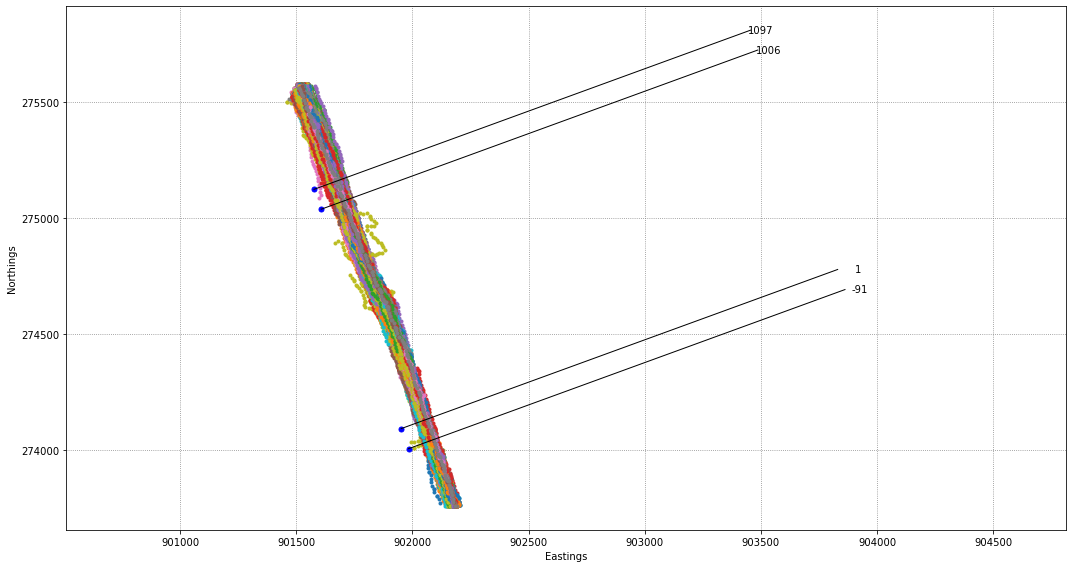

In [36]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)

# for GIS applications, save output into a GEOJSON layer
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = {'init':'epsg:'+str(settings['output_epsg'])} # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

# load transects
fn_transects = os.path.join(data_folder, '%s_transects.geojson'%sitename)
gdf_transects = gpd.read_file(fn_transects)
print('Loaded transects in epsg:%d'%gdf_transects.crs.to_epsg())
gdf_transects.to_crs(epsg=settings['output_epsg'], inplace=True)
print('Converted to epsg:%d'%gdf_transects.crs.to_epsg())
# put transects into a dictionary with their name
selected_transects = [-91,1,1006,1097]
selected_transects = ['%d'%_ for _ in selected_transects]
transects = dict([])
for i in gdf_transects.index:
    if gdf_transects.loc[i,'name'] in selected_transects:
        transects[gdf_transects.loc[i,'name']] = np.array(gdf_transects.loc[i,'geometry'].coords)

# plot the transects to make sure they are correct (origin landwards!)
%matplotlib inline
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][-1,0]+100, transects[key][-1,1], key,
                va='center', ha='right')
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'mapped_shorelines.jpg'),dpi=200)

# compute the intersections
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'prc_multiple':         0.1,      # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

# save a .csv file for each transect for submission
for key in transects.keys():
    out_dict = dict([])
    out_dict['dates'] = output['dates']
    out_dict[key] = cross_distance[key]
    out_dict['satname'] = output['satname']
    df = pd.DataFrame(out_dict)
    df.index=df['dates']
    df.pop('dates')
    fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                      '%s_timeseries_raw.csv'%key)
    df.to_csv(fn, sep=',')
    print('saved: %s'%fn)

### Tidal correction

Extracting closest points: 100%-91  - outliers removed: 1
1  - outliers removed: 3
1006  - outliers removed: 3
1097  - outliers removed: 5
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\DUCK\-91_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\DUCK\1_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\DUCK\1006_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\DUCK\1097_timeseries_tidally_corrected.csv


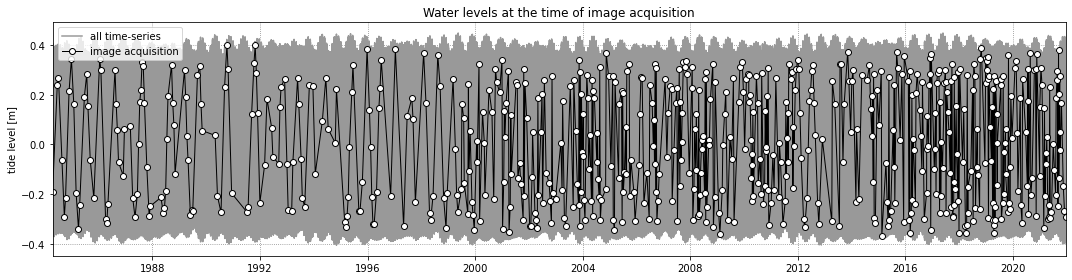

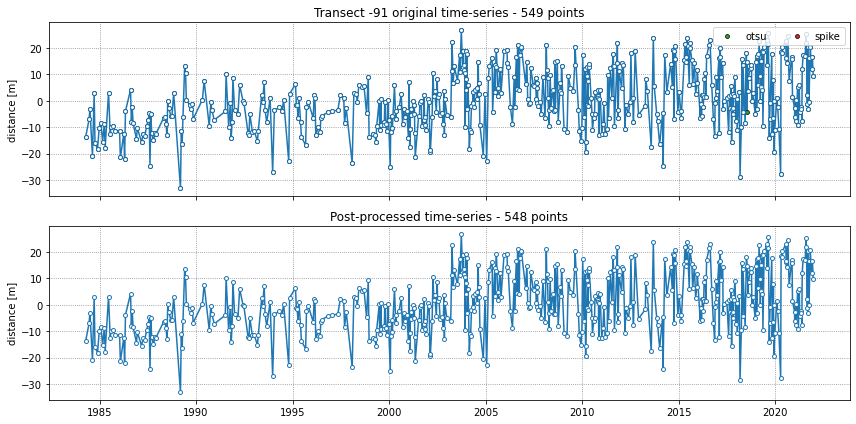

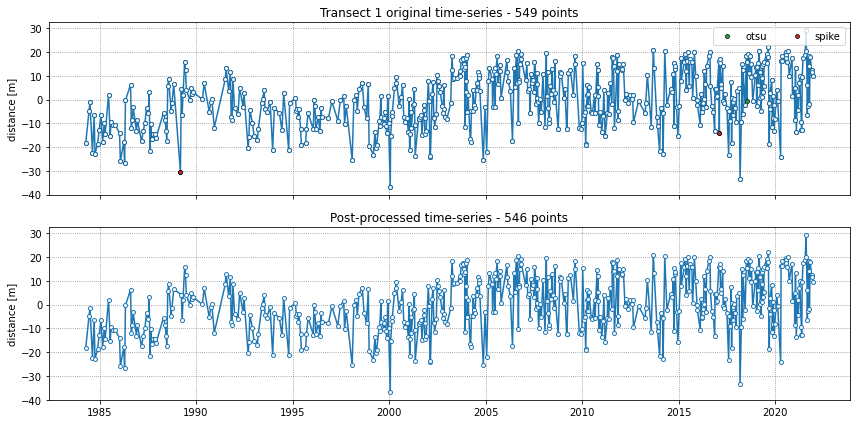

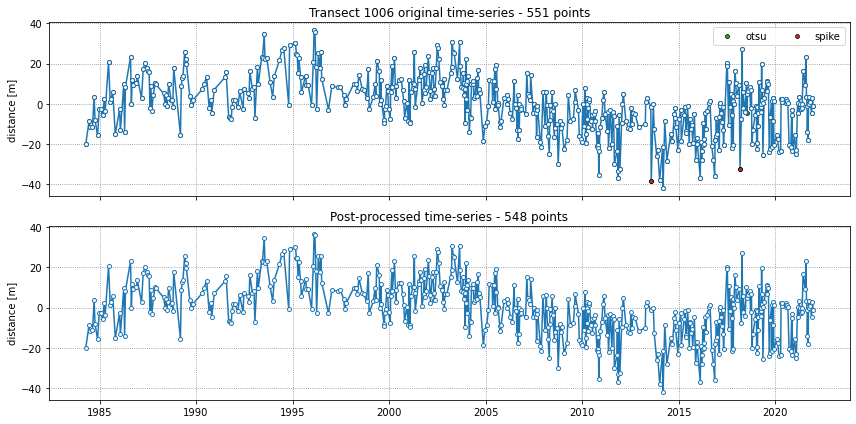

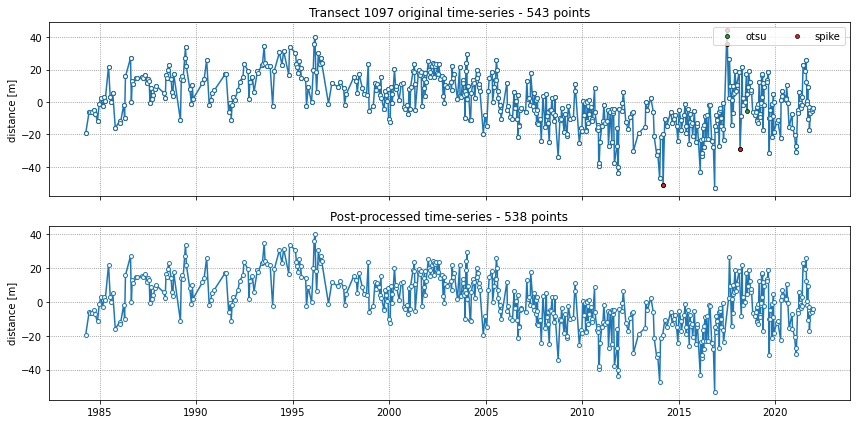

In [37]:
# load tide time-series
fn_tides = os.path.join(data_folder,'%s_tides.csv'%sitename)
tide_data = pd.read_csv(fn_tides, parse_dates=['dates'])
dates_ts = [pytz.utc.localize(_.to_pydatetime()) for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tides'])

# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)

# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(tide_data['dates'], tide_data['tides'], '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Water levels at the time of image acquisition')
ax.legend()
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'tide_timeseries.jpg'),dpi=200)

# tidal correction along each transect
reference_elevation = sites_info[sitename]['contour_level'] # elevation at which you would like the shoreline time-series to be
beach_slope = sites_info[sitename]['beach_slope']
cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/beach_slope
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    
# remove outliers in the time-series (despiking)
settings_outliers = {'otsu_threshold':     [-.5,0],       # min and max intensity threshold use for contouring the shoreline
                     'max_cross_change':   30,            # maximum cross-shore change observable between consecutive timesteps
                     'plot_fig':           True,          # whether to plot the intermediate steps
                    }
cross_distance_tidally_corrected = SDS_transects.reject_outliers(cross_distance_tidally_corrected,output,settings_outliers)

# save a .csv file for each transect for submission
for key in transects.keys():
    out_dict = dict([])
    out_dict['dates'] = output['dates']
    out_dict[key] = cross_distance_tidally_corrected[key]
    out_dict['satname'] = output['satname']
    df = pd.DataFrame(out_dict)
    df.index=df['dates']
    df.pop('dates')
    fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                      '%s_timeseries_tidally_corrected.csv'%key)
    df.to_csv(fn, sep=',')
    print('saved: %s'%fn)
    
# # plot the time-series of shoreline change (both raw and tidally-corrected)
# fig = plt.figure(figsize=[15,15], tight_layout=True)
# gs = gridspec.GridSpec(len(cross_distance),1)
# gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.1)
# for i,key in enumerate(cross_distance.keys()):
#     if np.all(np.isnan(cross_distance[key])):
#         continue
#     ax = fig.add_subplot(gs[i,0])
#     ax.grid(linestyle=':', color='0.5')
#     ax.plot(output['dates'], cross_distance[key]- np.nanmedian(cross_distance[key]), '-o', ms=4, mfc='w', label='raw')
#     ax.set_ylabel('distance [m]', fontsize=12)
#     ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
#             va='top', transform=ax.transAxes, fontsize=14)
# ax.legend();
# fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'shoreline_timeseries.jpg'),dpi=200)


### Compare to groundtruth

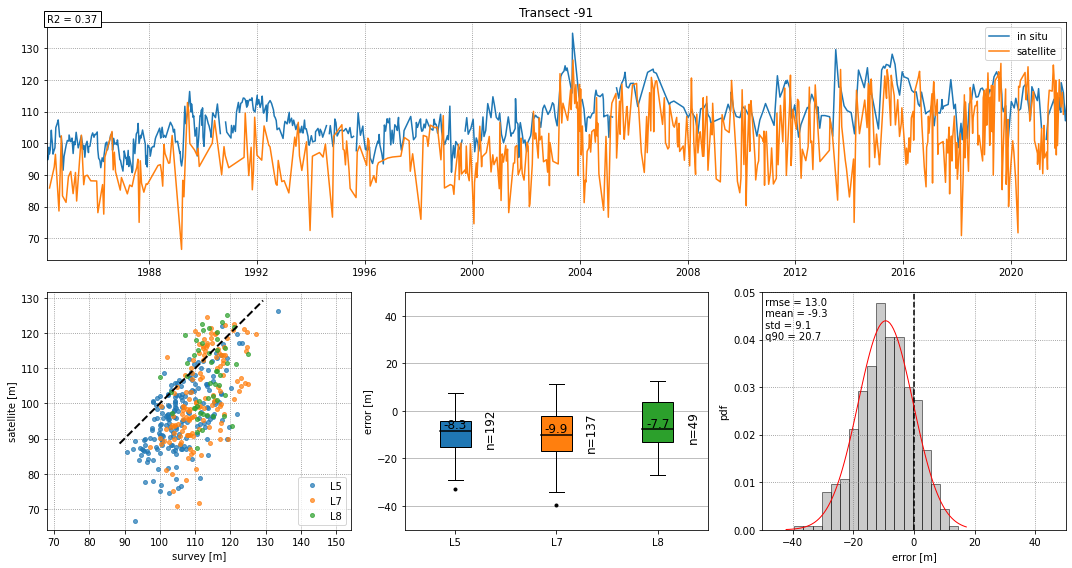

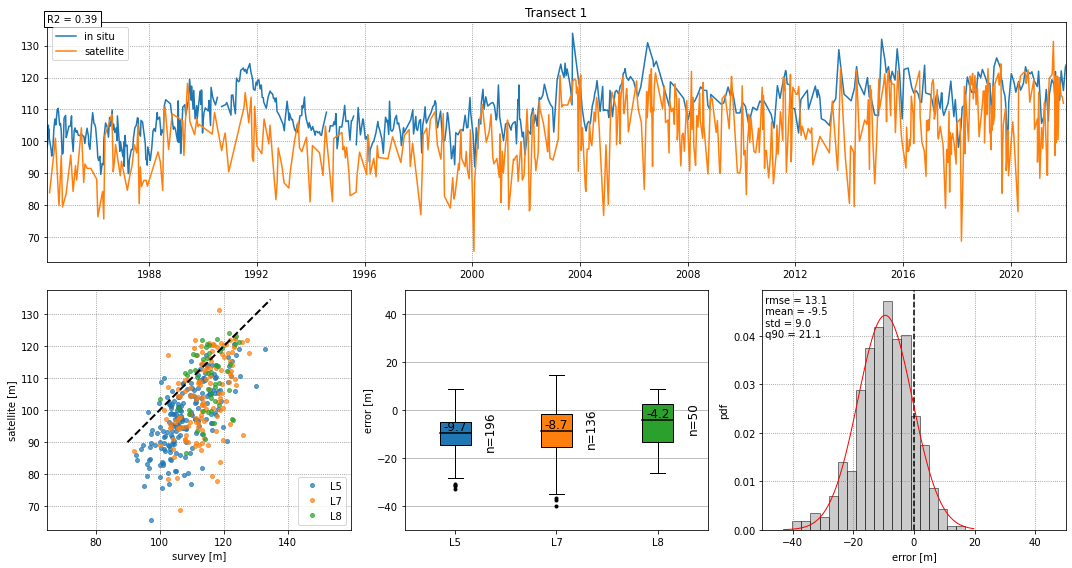

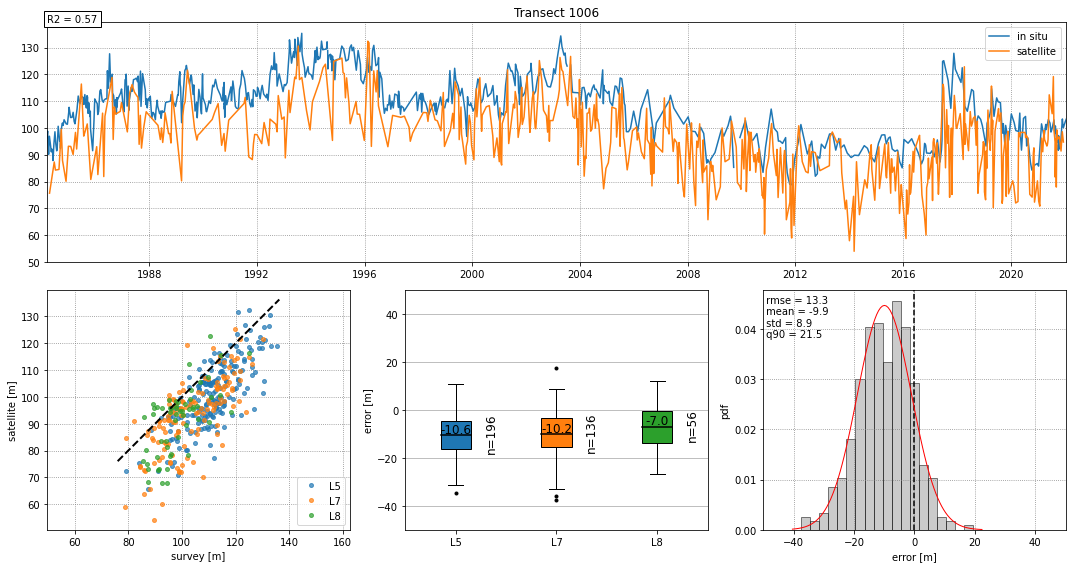

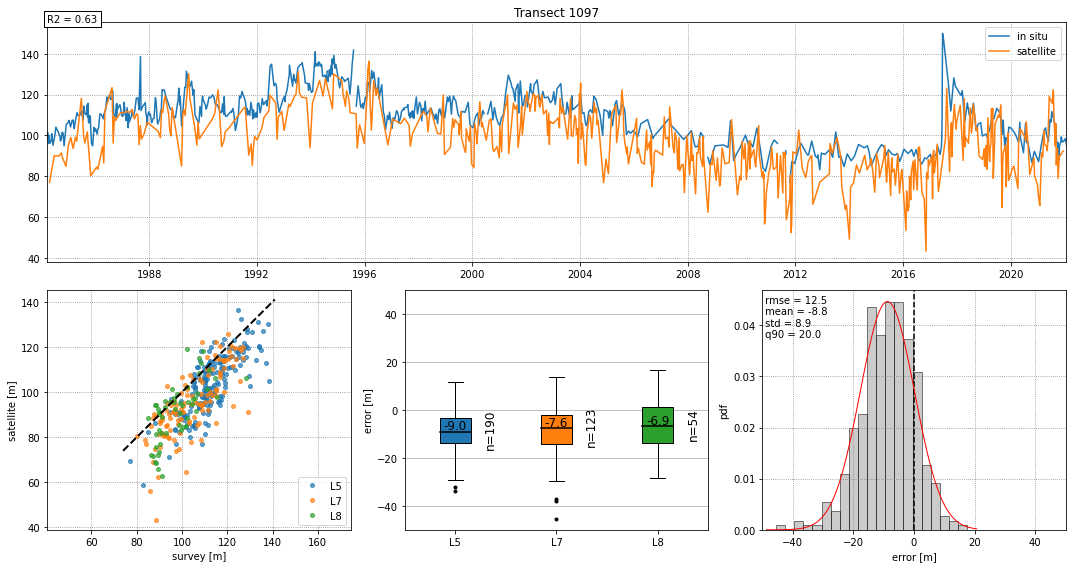

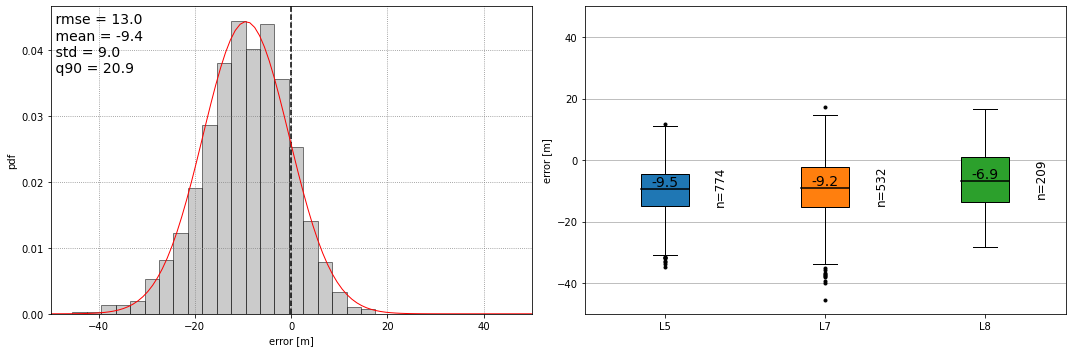

In [38]:
# set parameters for comparing the two time-series
sett = {'min_days':  3,       # numbers of days difference under which to use nearest neighbour interpolation
        'max_days':  10,      # maximum number of days difference to do a comparison
        'binwidth':  3,       # binwidth for histogram plotting
        'lims':      [-50,50] # cross-shore change limits for plotting purposes
       }
# load survey data
with open(os.path.join(data_folder, '%s_groundtruth.pkl'%sitename), 'rb') as f:
    gt = pickle.load(f)
    
# initialise variables
chain_sat_all = []
chain_sur_all = []
satnames_all = []
for key in cross_distance_tidally_corrected.keys():
    if key not in gt.keys(): continue
    # remove nans
    chainage = cross_distance_tidally_corrected[key]
    idx_nan = np.isnan(chainage)
    dates_nonans = [output['dates'][k] for k in np.where(~idx_nan)[0]]
    satnames_nonans = [output['satname'][k] for k in np.where(~idx_nan)[0]]
    chain_nonans = chainage[~idx_nan]
    # define satellite and survey time-series
    chain_sat_dm = chain_nonans
    chain_sur_dm = gt[key]['chainages']
    # plot the time-series
    fig= plt.figure(figsize=[15,8], tight_layout=True)
    gs = gridspec.GridSpec(2,3)
    ax0 = fig.add_subplot(gs[0,:])
    ax0.grid(which='major',linestyle=':',color='0.5')
    ax0.plot(gt[key]['dates'], chain_sur_dm, '-',mfc='w',ms=5,label='in situ')
    ax0.plot(dates_nonans, chain_sat_dm,'-',mfc='w',ms=5,label='satellite')
    ax0.set(title= 'Transect ' + key, xlim=[output['dates'][0]-timedelta(days=30),
                                           output['dates'][-1]+timedelta(days=30)])#,ylim=sett['lims'])
    ax0.legend()
    # interpolate surveyed data around satellite data based on the parameters (min_days and max_days)
    chain_int = np.nan*np.ones(len(dates_nonans))
    for k,date in enumerate(dates_nonans):
        # compute the days distance for each satellite date
        days_diff = np.array([ (_ - date).days for _ in gt[key]['dates']])
        # if nothing within max_days put a nan
        if np.min(np.abs(days_diff)) > sett['max_days']:
            chain_int[k] = np.nan
        else:
            # if a point within min_days, take that point (no interpolation)
            if np.min(np.abs(days_diff)) < sett['min_days']:
                idx_closest = np.where(np.abs(days_diff) == np.min(np.abs(days_diff)))
                chain_int[k] = float(gt[key]['chainages'][idx_closest[0][0]])
            else: # otherwise, between min_days and max_days, interpolate between the 2 closest points
                if sum(days_diff > 0) == 0:
                    break
                idx_after = np.where(days_diff > 0)[0][0]
                idx_before = idx_after - 1
                x = [gt[key]['dates'][idx_before].toordinal() , gt[key]['dates'][idx_after].toordinal()]
                y = [gt[key]['chainages'][idx_before], gt[key]['chainages'][idx_after]]
                try:
                    f = interpolate.interp1d(x, y,bounds_error=True)
                    chain_int[k] = float(f(date.toordinal()))
                except:
                    chain_int[k] = np.nan 
    # remove nans again
    idx_nan = np.isnan(chain_int)
    chain_sat = chain_nonans[~idx_nan]
    chain_sur = chain_int[~idx_nan]
    dates_sat = [dates_nonans[k] for k in np.where(~idx_nan)[0]]
    satnames = [satnames_nonans[k] for k in np.where(~idx_nan)[0]]
    chain_sat_all = np.append(chain_sat_all,chain_sat)
    chain_sur_all = np.append(chain_sur_all,chain_sur)
    satnames_all = satnames_all + satnames
    # error statistics
    slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat)
    R2 = rvalue**2
    ax0.text(0,1,'R2 = %.2f'%R2,bbox=dict(boxstyle='square', facecolor='w', alpha=1),transform=ax0.transAxes)
    chain_error = chain_sat - chain_sur
    rmse = np.sqrt(np.mean((chain_error)**2))
    mean = np.mean(chain_error)
    std = np.std(chain_error)
    q90 = np.percentile(np.abs(chain_error), 90)
    # 1:1 plot
    ax1 = fig.add_subplot(gs[1,0])
    ax1.axis('equal')
    ax1.grid(which='major',linestyle=':',color='0.5')
    for k,sat in enumerate(list(np.unique(satnames))):
        idx = np.where([_ == sat for _ in satnames])[0]
        ax1.plot(chain_sur[idx], chain_sat[idx], 'o', ms=4, mfc='C'+str(k),mec='C'+str(k), alpha=0.7, label=sat)
    ax1.legend(loc=4)
    ax1.plot([ax1.get_xlim()[0], ax1.get_ylim()[1]],[ax1.get_xlim()[0], ax1.get_ylim()[1]],'k--',lw=2)
    ax1.set(xlabel='survey [m]', ylabel='satellite [m]')
    # boxplots
    ax2 = fig.add_subplot(gs[1,1])
    data = []
    median_data = []
    n_data = []
    ax2.yaxis.grid()
    for k,sat in enumerate(list(np.unique(satnames))):
        idx = np.where([_ == sat for _ in satnames])[0]
        data.append(chain_error[idx])
        median_data.append(np.median(chain_error[idx]))
        n_data.append(len(chain_error[idx]))
    bp = ax2.boxplot(data,0,'k.', labels=list(np.unique(satnames)), patch_artist=True)
    for median in bp['medians']:
        median.set(color='k', linewidth=1.5)
    for j,boxes in enumerate(bp['boxes']):
        boxes.set(facecolor='C'+str(j))
        ax2.text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=12)
        ax2.text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
    ax2.set(ylabel='error [m]', ylim=sett['lims'])
    # histogram
    ax3 = fig.add_subplot(gs[1,2])
    ax3.grid(which='major',linestyle=':',color='0.5')
    ax3.axvline(x=0, ls='--', lw=1.5, color='k')
    binwidth=sett['binwidth']
    bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
    density = plt.hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
    mu, std = stats.norm.fit(chain_error)
    pval = stats.normaltest(chain_error)[1]
    xlims = ax3.get_xlim()
    x = np.linspace(xlims[0], xlims[1], 100)
    p = stats.norm.pdf(x, mu, std)
    ax3.plot(x, p, 'r-', linewidth=1)
    ax3.set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])
    str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90)
    ax3.text(0, 0.98, str_stats,va='top', transform=ax3.transAxes)
    # save plot
    fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'],'%s_comparison_transect_%s.jpg'%(sitename,key)), dpi=150)
# calculate statistics for all transects together
chain_error = chain_sat_all - chain_sur_all
slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat)
R2 = rvalue**2
rmse = np.sqrt(np.mean((chain_error)**2))
mean = np.mean(chain_error)
std = np.std(chain_error)
q90 = np.percentile(np.abs(chain_error), 90)
fig,ax = plt.subplots(1,2,figsize=(15,5), tight_layout=True)
# histogram
ax[0].grid(which='major',linestyle=':',color='0.5')
ax[0].axvline(x=0, ls='--', lw=1.5, color='k')
binwidth=sett['binwidth']
bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
density = ax[0].hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
mu, std = stats.norm.fit(chain_error)
pval = stats.normaltest(chain_error)[1]
xlims = ax3.get_xlim()
x = np.linspace(xlims[0], xlims[1], 100)
p = stats.norm.pdf(x, mu, std)
ax[0].plot(x, p, 'r-', linewidth=1)
ax[0].set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])
str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90)
ax[0].text(0, 0.98, str_stats,va='top', transform=ax[0].transAxes,fontsize=14)
# boxplot
data = []
median_data = []
n_data = []
ax[1].yaxis.grid()
for k,sat in enumerate(list(np.unique(satnames_all))):
    idx = np.where([_ == sat for _ in satnames_all])[0]
    data.append(chain_error[idx])
    median_data.append(np.median(chain_error[idx]))
    n_data.append(len(chain_error[idx]))
bp = ax[1].boxplot(data,0,'k.', labels=list(np.unique(satnames_all)), patch_artist=True)
for median in bp['medians']:
    median.set(color='k', linewidth=1.5)
for j,boxes in enumerate(bp['boxes']):
    boxes.set(facecolor='C'+str(j))
    ax[1].text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=14)
    ax[1].text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
ax[1].set(ylabel='error [m]', ylim=sett['lims']);
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'],'%s_comparison_all_transects.jpg'%sitename), dpi=150)

END DUCK

## 3. Truc Vert, France

In [39]:
# loop over each site (for the moment only NARRABEEN)
sitename = 'TRUCVERT'
inputs = {}
inputs['sitename'] = sitename
inputs['filepath'] =  os.path.join(os.getcwd(),'satellite_data')
inputs['landsat_collection'] = 'C01'
inputs['dates'] =  ['1984-01-01', '2022-01-01']
inputs['sat_list'] = ['L5','L7','L8','S2']
data_folder = os.path.join(fp_datasets,sitename)

metadata = SDS_download.get_metadata(inputs)
metadata.pop('S2');

### Shoreline extraction (fully automated)

In [40]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 32630,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': False,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': True,   # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    # add the inputs defined previously
    'inputs': inputs,
}
# take epsg from sites_info 
settings['output_epsg'] = sites_info[sitename]['epsg']
# load the reference shoreline
fn_refsl = os.path.join(data_folder, '%s_reference_shoreline.geojson'%sitename)
gdf_refsl = gpd.read_file(fn_refsl)
print('Loaded reference shoreline in epsg:%d'%gdf_refsl.crs.to_epsg())
gdf_refsl.to_crs(epsg=settings['output_epsg'], inplace=True)
print('Converted to epsg:%d'%gdf_refsl.crs.to_epsg())
refsl = np.array(gdf_refsl.loc[0,'geometry'].coords)
settings['reference_shoreline'] = refsl
# set the max distance (in meters) allowed from the reference shoreline for a detected shoreline to be valid
settings['max_dist_ref'] = 100
# extract shorelines from all images (creates or loads output.pkl)
fn_output = os.path.join(inputs['filepath'], sitename, sitename + '_output' + '.pkl')
if os.path.exists(fn_output):
    with open(fn_output, 'rb') as f:
        output = pickle.load(f)
    print('loaded existing file at %s'%fn_output)
else:
    output = SDS_shoreline.extract_shorelines(metadata, settings)
    # remove duplicates (images taken on the same date by the same satellite)
    output = SDS_tools.remove_duplicates(output)
    # remove inaccurate georeferencing (set threshold to 10 m)
    output = SDS_tools.remove_inaccurate_georef(output, 10)
    # remove bad images based on average classification (only works for same resolution, Landsat)
    if not 'S2' in metadata.keys():
        # settings for discarding the badly classified images"
        settings['prc_pixel'] = 0.15    # minimum percentage of change from land to water for defining the wet/dry areas
        settings['prc_image'] = 0.3     # maximum percentage of misclassified pixels allowed in the image, otherwise discarded
        output = SDS_shoreline.remove_bad_images(output,settings)
    else:
        output.pop('im_classif')
        with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'wb') as f:
            pickle.dump(output,f)

Loaded reference shoreline in epsg:4326
Converted to epsg:32630
loaded existing file at C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\TRUCVERT\TRUCVERT_output.pkl


### Shoreline analysis

Loaded transects in epsg:4326
Converted to epsg:32630
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\TRUCVERT\-400_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\TRUCVERT\-300_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\TRUCVERT\-200_timeseries_raw.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\TRUCVERT\-100_timeseries_raw.csv


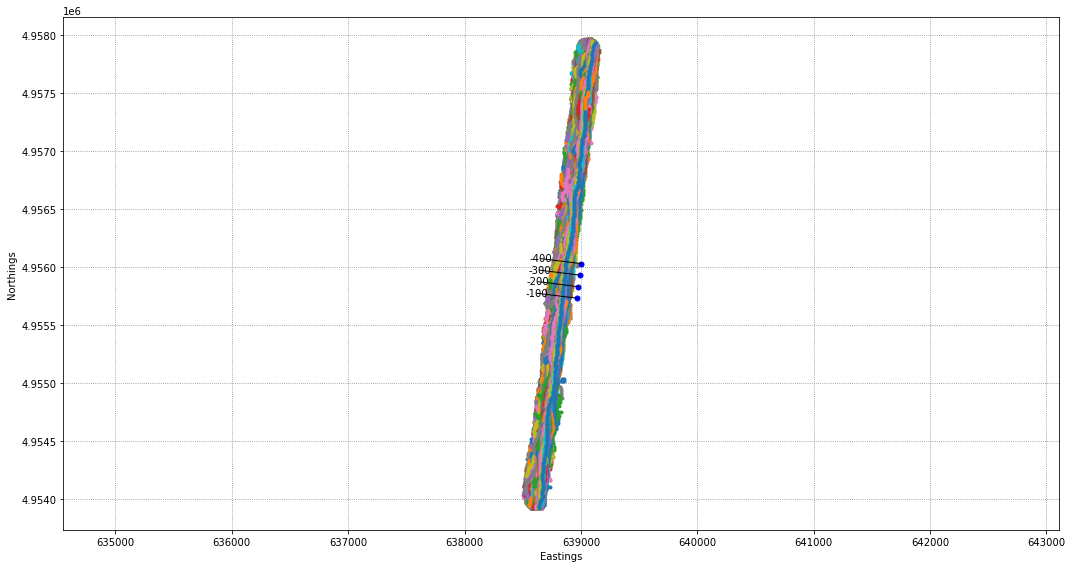

In [41]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)

# for GIS applications, save output into a GEOJSON layer
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = {'init':'epsg:'+str(settings['output_epsg'])} # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

# load transects
fn_transects = os.path.join(data_folder, '%s_transects.geojson'%sitename)
gdf_transects = gpd.read_file(fn_transects)
print('Loaded transects in epsg:%d'%gdf_transects.crs.to_epsg())
gdf_transects.to_crs(epsg=settings['output_epsg'], inplace=True)
print('Converted to epsg:%d'%gdf_transects.crs.to_epsg())
# put transects into a dictionary with their name
selected_transects = [-400,-300,-200,-100]
selected_transects = ['%d'%_ for _ in selected_transects]
transects = dict([])
for i in gdf_transects.index:
    if gdf_transects.loc[i,'name'] in selected_transects:
        transects[gdf_transects.loc[i,'name']] = np.array(gdf_transects.loc[i,'geometry'].coords)

# plot the transects to make sure they are correct (origin landwards!)
%matplotlib inline
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][-1,0]+100, transects[key][-1,1], key,
                va='center', ha='right')
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'mapped_shorelines.jpg'),dpi=200)

# compute the intersections
settings_transects = { # parameters for computing intersections
                      'along_dist':          50,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        0,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'nan',    # mode for removing outliers ('auto', 'nan', 'max')
                      'prc_multiple':         0.1,      # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

# save a .csv file for each transect for submission
for key in transects.keys():
    out_dict = dict([])
    out_dict['dates'] = output['dates']
    out_dict[key] = cross_distance[key]
    out_dict['satname'] = output['satname']
    df = pd.DataFrame(out_dict)
    df.index=df['dates']
    df.pop('dates')
    fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                      '%s_timeseries_raw.csv'%key)
    df.to_csv(fn, sep=',')
    print('saved: %s'%fn)

### Tidal correction

Extracting closest points: 100%-400  - outliers removed: 16
-300  - outliers removed: 10
-200  - outliers removed: 6
-100  - outliers removed: 5
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\TRUCVERT\-400_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\TRUCVERT\-300_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\TRUCVERT\-200_timeseries_tidally_corrected.csv
saved: C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data\TRUCVERT\-100_timeseries_tidally_corrected.csv


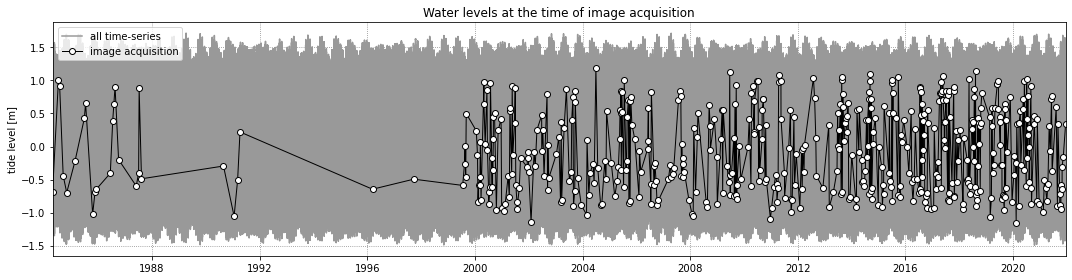

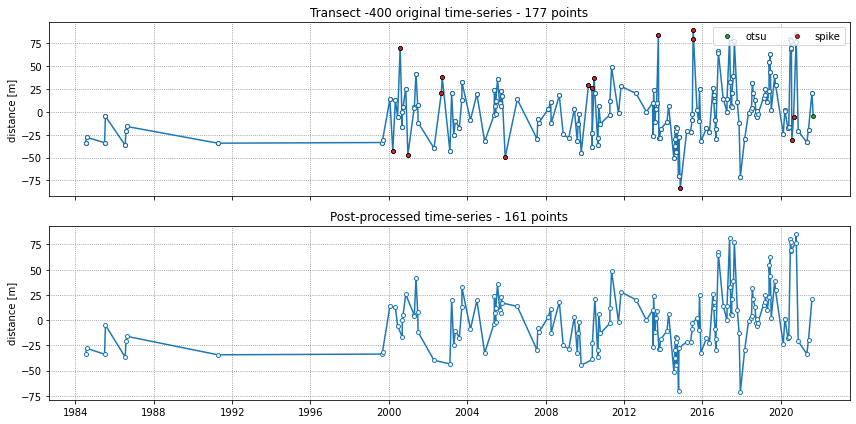

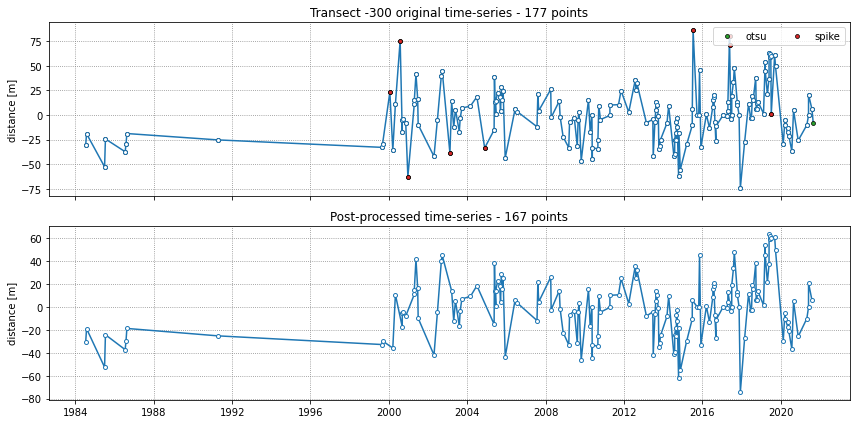

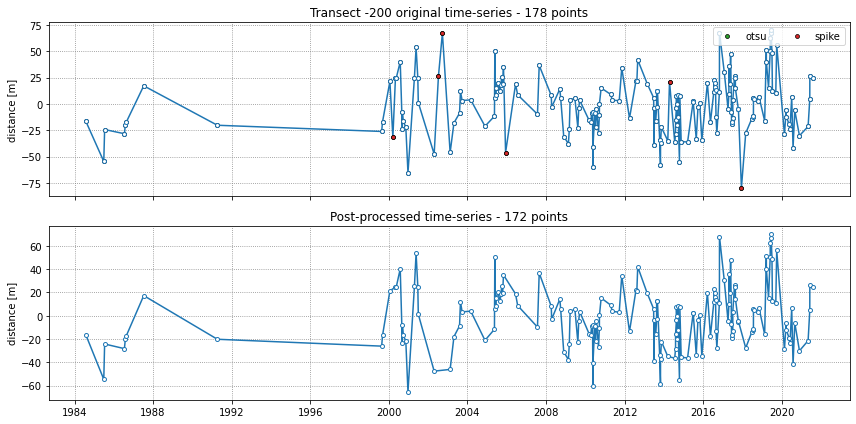

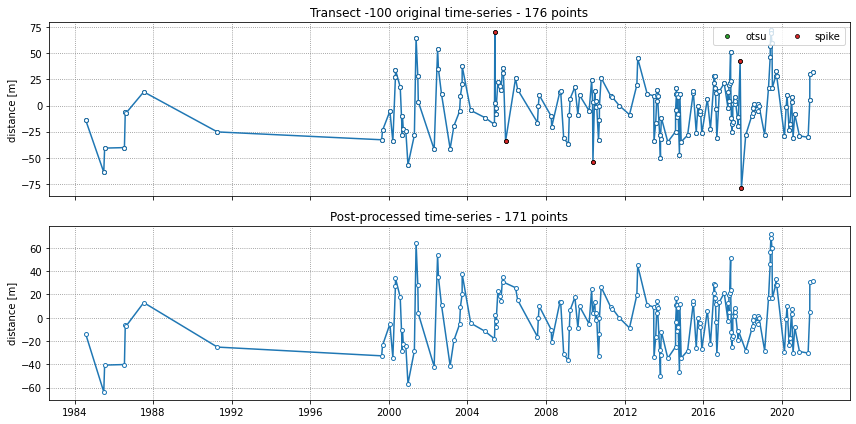

In [42]:
# load tide time-series
fn_tides = os.path.join(data_folder,'%s_tides.csv'%sitename)
tide_data = pd.read_csv(fn_tides, parse_dates=['dates'])
dates_ts = [pytz.utc.localize(_.to_pydatetime()) for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tides'])

# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)

# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(tide_data['dates'], tide_data['tides'], '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Water levels at the time of image acquisition')
ax.legend()
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'tide_timeseries.jpg'),dpi=200)

# tidal correction along each transect
reference_elevation = sites_info[sitename]['contour_level'] # elevation at which you would like the shoreline time-series to be
beach_slope = sites_info[sitename]['beach_slope']
cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/beach_slope
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction

# remove low tide images
for key in cross_distance_tidally_corrected.keys():
    for i in range(len(cross_distance_tidally_corrected[key])):
        if tides_sat[i] < 0: cross_distance_tidally_corrected[key][i] = np.nan
    
# remove outliers in the time-series (despiking)
settings_outliers = {'otsu_threshold':     [-.5,0],       # min and max intensity threshold use for contouring the shoreline
                     'max_cross_change':   50,            # maximum cross-shore change observable between consecutive timesteps
                     'plot_fig':           True,          # whether to plot the intermediate steps
                    }
cross_distance_tidally_corrected = SDS_transects.reject_outliers(cross_distance_tidally_corrected,output,settings_outliers)

# save a .csv file for each transect for submission
for key in transects.keys():
    out_dict = dict([])
    out_dict['dates'] = output['dates']
    out_dict[key] = cross_distance_tidally_corrected[key]
    out_dict['satname'] = output['satname']
    df = pd.DataFrame(out_dict)
    df.index=df['dates']
    df.pop('dates')
    fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                      '%s_timeseries_tidally_corrected.csv'%key)
    df.to_csv(fn, sep=',')
    print('saved: %s'%fn)
    
# # plot the time-series of shoreline change (both raw and tidally-corrected)
# fig = plt.figure(figsize=[15,15], tight_layout=True)
# gs = gridspec.GridSpec(len(cross_distance),1)
# gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.1)
# for i,key in enumerate(cross_distance.keys()):
#     if np.all(np.isnan(cross_distance[key])):
#         continue
#     ax = fig.add_subplot(gs[i,0])
#     ax.grid(linestyle=':', color='0.5')
#     ax.plot(output['dates'], cross_distance[key]- np.nanmedian(cross_distance[key]), '-o', ms=4, mfc='w', label='raw')
#     ax.set_ylabel('distance [m]', fontsize=12)
#     ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
#             va='top', transform=ax.transAxes, fontsize=14)
# ax.legend();
# fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'shoreline_timeseries.jpg'),dpi=200)


### Compare to groundtruth

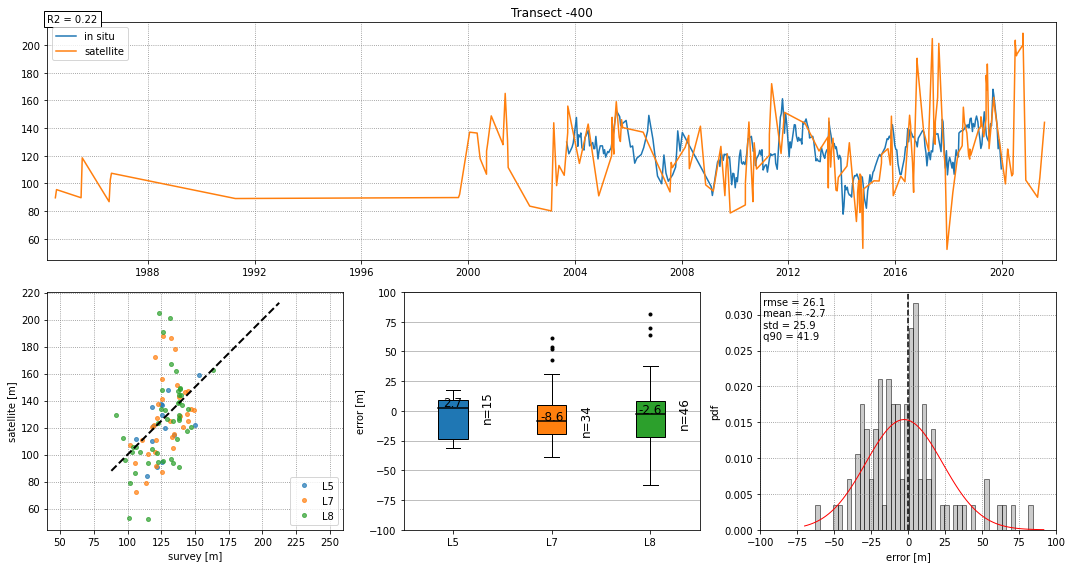

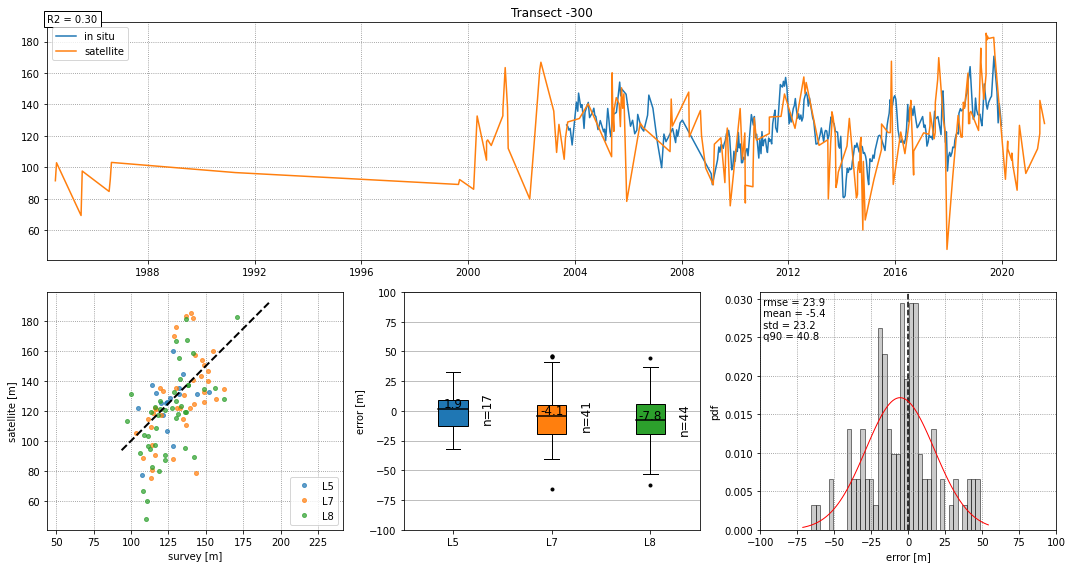

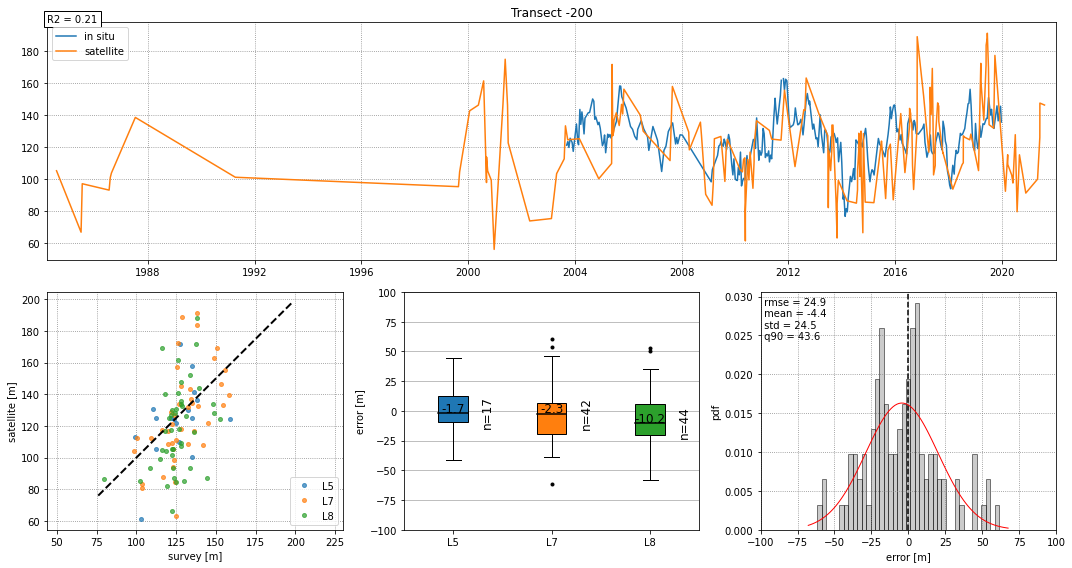

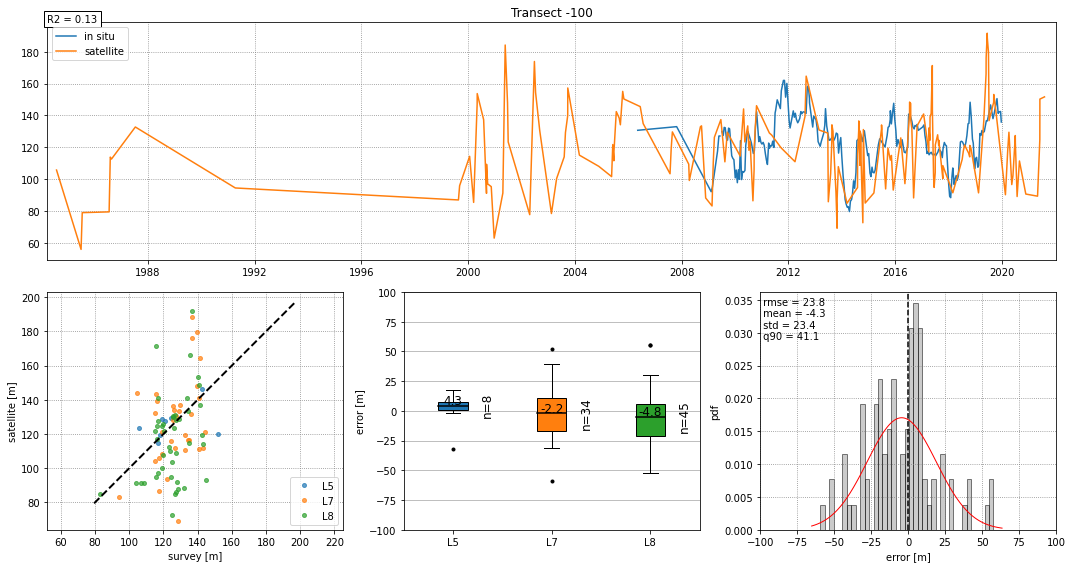

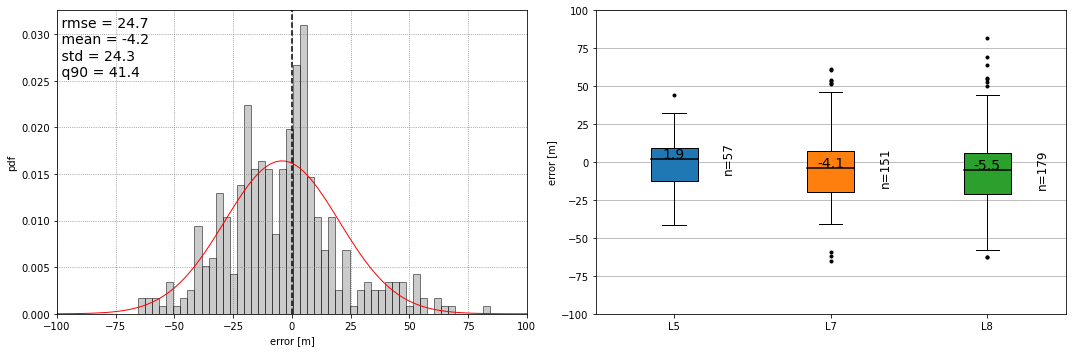

In [43]:
# set parameters for comparing the two time-series
sett = {'min_days':  3,       # numbers of days difference under which to use nearest neighbour interpolation
        'max_days':  10,      # maximum number of days difference to do a comparison
        'binwidth':  3,       # binwidth for histogram plotting
        'lims':      [-100,100] # cross-shore change limits for plotting purposes
       }
# load survey data
with open(os.path.join(data_folder, '%s_groundtruth.pkl'%sitename), 'rb') as f:
    gt = pickle.load(f)
    
# initialise variables
chain_sat_all = []
chain_sur_all = []
satnames_all = []
for key in cross_distance_tidally_corrected.keys():
    if key not in gt.keys(): continue
    # remove nans
    chainage = cross_distance_tidally_corrected[key]
    idx_nan = np.isnan(chainage)
    dates_nonans = [output['dates'][k] for k in np.where(~idx_nan)[0]]
    satnames_nonans = [output['satname'][k] for k in np.where(~idx_nan)[0]]
    chain_nonans = chainage[~idx_nan]
    # define satellite and survey time-series
    chain_sat_dm = chain_nonans
    chain_sur_dm = gt[key]['chainages']
    # plot the time-series
    fig= plt.figure(figsize=[15,8], tight_layout=True)
    gs = gridspec.GridSpec(2,3)
    ax0 = fig.add_subplot(gs[0,:])
    ax0.grid(which='major',linestyle=':',color='0.5')
    ax0.plot(gt[key]['dates'], chain_sur_dm, '-',mfc='w',ms=5,label='in situ')
    ax0.plot(dates_nonans, chain_sat_dm,'-',mfc='w',ms=5,label='satellite')
    ax0.set(title= 'Transect ' + key, xlim=[output['dates'][0]-timedelta(days=30),
                                           output['dates'][-1]+timedelta(days=30)])#,ylim=sett['lims'])
    ax0.legend()
    # interpolate surveyed data around satellite data based on the parameters (min_days and max_days)
    chain_int = np.nan*np.ones(len(dates_nonans))
    for k,date in enumerate(dates_nonans):
        # compute the days distance for each satellite date
        days_diff = np.array([ (_ - date).days for _ in gt[key]['dates']])
        # if nothing within max_days put a nan
        if np.min(np.abs(days_diff)) > sett['max_days']:
            chain_int[k] = np.nan
        else:
            # if a point within min_days, take that point (no interpolation)
            if np.min(np.abs(days_diff)) < sett['min_days']:
                idx_closest = np.where(np.abs(days_diff) == np.min(np.abs(days_diff)))
                chain_int[k] = float(gt[key]['chainages'][idx_closest[0][0]])
            else: # otherwise, between min_days and max_days, interpolate between the 2 closest points
                if sum(days_diff > 0) == 0:
                    break
                idx_after = np.where(days_diff > 0)[0][0]
                idx_before = idx_after - 1
                x = [gt[key]['dates'][idx_before].toordinal() , gt[key]['dates'][idx_after].toordinal()]
                y = [gt[key]['chainages'][idx_before], gt[key]['chainages'][idx_after]]
                try:
                    f = interpolate.interp1d(x, y,bounds_error=True)
                    chain_int[k] = float(f(date.toordinal()))
                except:
                    chain_int[k] = np.nan 
    # remove nans again
    idx_nan = np.isnan(chain_int)
    chain_sat = chain_nonans[~idx_nan]
    chain_sur = chain_int[~idx_nan]
    dates_sat = [dates_nonans[k] for k in np.where(~idx_nan)[0]]
    satnames = [satnames_nonans[k] for k in np.where(~idx_nan)[0]]
    chain_sat_all = np.append(chain_sat_all,chain_sat)
    chain_sur_all = np.append(chain_sur_all,chain_sur)
    satnames_all = satnames_all + satnames
    # error statistics
    slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat)
    R2 = rvalue**2
    ax0.text(0,1,'R2 = %.2f'%R2,bbox=dict(boxstyle='square', facecolor='w', alpha=1),transform=ax0.transAxes)
    chain_error = chain_sat - chain_sur
    rmse = np.sqrt(np.mean((chain_error)**2))
    mean = np.mean(chain_error)
    std = np.std(chain_error)
    q90 = np.percentile(np.abs(chain_error), 90)
    # 1:1 plot
    ax1 = fig.add_subplot(gs[1,0])
    ax1.axis('equal')
    ax1.grid(which='major',linestyle=':',color='0.5')
    for k,sat in enumerate(list(np.unique(satnames))):
        idx = np.where([_ == sat for _ in satnames])[0]
        ax1.plot(chain_sur[idx], chain_sat[idx], 'o', ms=4, mfc='C'+str(k),mec='C'+str(k), alpha=0.7, label=sat)
    ax1.legend(loc=4)
    ax1.plot([ax1.get_xlim()[0], ax1.get_ylim()[1]],[ax1.get_xlim()[0], ax1.get_ylim()[1]],'k--',lw=2)
    ax1.set(xlabel='survey [m]', ylabel='satellite [m]')
    # boxplots
    ax2 = fig.add_subplot(gs[1,1])
    data = []
    median_data = []
    n_data = []
    ax2.yaxis.grid()
    for k,sat in enumerate(list(np.unique(satnames))):
        idx = np.where([_ == sat for _ in satnames])[0]
        data.append(chain_error[idx])
        median_data.append(np.median(chain_error[idx]))
        n_data.append(len(chain_error[idx]))
    bp = ax2.boxplot(data,0,'k.', labels=list(np.unique(satnames)), patch_artist=True)
    for median in bp['medians']:
        median.set(color='k', linewidth=1.5)
    for j,boxes in enumerate(bp['boxes']):
        boxes.set(facecolor='C'+str(j))
        ax2.text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=12)
        ax2.text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
    ax2.set(ylabel='error [m]', ylim=sett['lims'])
    # histogram
    ax3 = fig.add_subplot(gs[1,2])
    ax3.grid(which='major',linestyle=':',color='0.5')
    ax3.axvline(x=0, ls='--', lw=1.5, color='k')
    binwidth=sett['binwidth']
    bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
    density = plt.hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
    mu, std = stats.norm.fit(chain_error)
    pval = stats.normaltest(chain_error)[1]
    xlims = ax3.get_xlim()
    x = np.linspace(xlims[0], xlims[1], 100)
    p = stats.norm.pdf(x, mu, std)
    ax3.plot(x, p, 'r-', linewidth=1)
    ax3.set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])
    str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90)
    ax3.text(0, 0.98, str_stats,va='top', transform=ax3.transAxes)
    # save plot
    fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'],'%s_comparison_transect_%s.jpg'%(sitename,key)), dpi=150)
# calculate statistics for all transects together
chain_error = chain_sat_all - chain_sur_all
slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat)
R2 = rvalue**2
rmse = np.sqrt(np.mean((chain_error)**2))
mean = np.mean(chain_error)
std = np.std(chain_error)
q90 = np.percentile(np.abs(chain_error), 90)
fig,ax = plt.subplots(1,2,figsize=(15,5), tight_layout=True)
# histogram
ax[0].grid(which='major',linestyle=':',color='0.5')
ax[0].axvline(x=0, ls='--', lw=1.5, color='k')
binwidth=sett['binwidth']
bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
density = ax[0].hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
mu, std = stats.norm.fit(chain_error)
pval = stats.normaltest(chain_error)[1]
xlims = ax3.get_xlim()
x = np.linspace(xlims[0], xlims[1], 100)
p = stats.norm.pdf(x, mu, std)
ax[0].plot(x, p, 'r-', linewidth=1)
ax[0].set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])
str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90)
ax[0].text(0, 0.98, str_stats,va='top', transform=ax[0].transAxes,fontsize=14)
# boxplot
data = []
median_data = []
n_data = []
ax[1].yaxis.grid()
for k,sat in enumerate(list(np.unique(satnames_all))):
    idx = np.where([_ == sat for _ in satnames_all])[0]
    data.append(chain_error[idx])
    median_data.append(np.median(chain_error[idx]))
    n_data.append(len(chain_error[idx]))
bp = ax[1].boxplot(data,0,'k.', labels=list(np.unique(satnames_all)), patch_artist=True)
for median in bp['medians']:
    median.set(color='k', linewidth=1.5)
for j,boxes in enumerate(bp['boxes']):
    boxes.set(facecolor='C'+str(j))
    ax[1].text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=14)
    ax[1].text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
ax[1].set(ylabel='error [m]', ylim=sett['lims']);
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'],'%s_comparison_all_transects.jpg'%sitename), dpi=150)

END TRUCVERT